# Libraries connection

In [132]:
import numpy as np
import pandas as pd
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import re

from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
# from sklearn.feature_selection import SelectKBest
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold
# from sklearn.model_selection import GridSearchCV
# from sklearn.feature_extraction.text import CountVectorizer

from zipfile import ZipFile
warnings.filterwarnings("ignore")

# Data extracting

- train, test: train and test samples
- target: probabilities of breaking
- df: raw data for generating self own train data

In [65]:
train = pd.read_csv("/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train_sessions.csv")

In [66]:
test = pd.read_csv("/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/test_sessions.csv")
submit = pd.read_csv("/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/sample_submission.csv")

In [4]:
archive = "/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train.zip"

zip_file = ZipFile(archive)
dict_df = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename)) for text_file in 
     zip_file.infolist() if text_file.filename.endswith(".csv")}

In [5]:
df = pd.DataFrame()
for key in dict_df.keys():
    df = pd.concat([df, dict_df[key]], axis=0)
df

,timestamp,site
0,2013-02-12 16:25:10,api.bing.com
1,2013-02-12 16:25:11,api.bing.com
2,2013-02-12 16:32:10,api.bing.com
3,2013-02-12 16:32:11,www.google.fr
4,2013-02-12 16:32:24,www.google.fr
...,...,...
1212,2014-03-17 17:00:09,twitter.com
1213,2014-03-17 17:00:09,s-static.ak.facebook.com
1214,2014-03-17 17:00:10,platform.twitter.com
1215,2014-03-17 17:00:10,login.live.com


In [6]:
with open('/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/site_dic.pkl', 'rb') as f:
    data = pickle.load(f)

# Recognize data structure

- session_id: identificator
- site_i: site identificator where i means number in current work session
- time_i: timestamp of entering to this site

In [8]:
train.head()

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
0,1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
2,3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
3,4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
4,5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [9]:
train.shape

(253561, 22)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253561 entries, 0 to 253560
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   session_id  253561 non-null  int64  
 1   site1       253561 non-null  int64  
 2   time1       253561 non-null  object 
 3   site2       250098 non-null  float64
 4   time2       250098 non-null  object 
 5   site3       246919 non-null  float64
 6   time3       246919 non-null  object 
 7   site4       244321 non-null  float64
 8   time4       244321 non-null  object 
 9   site5       241829 non-null  float64
 10  time5       241829 non-null  object 
 11  site6       239495 non-null  float64
 12  time6       239495 non-null  object 
 13  site7       237297 non-null  float64
 14  time7       237297 non-null  object 
 15  site8       235224 non-null  float64
 16  time8       235224 non-null  object 
 17  site9       233084 non-null  float64
 18  time9       233084 non-null  object 
 19  si

In [11]:
test.head()

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
0,1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,...,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
1,2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,...,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
2,3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,...,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
3,4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,...,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
4,5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,...,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [12]:
test.shape

(82797, 21)

In [36]:
train

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,digits_mean,digits_max,digits_min,digits_median,digits_std,words_mean,words_max,words_min,words_median,words_std
21668,21669,21.0,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,not known,NaT,not known,NaT,not known,...,3.0,3.0,3.0,3.0,0.000000,2.0,2.0,2.0,2.0,0.000000
54842,54843,24454.0,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,not known,...,2.8,4.0,0.0,3.0,1.032796,1.9,3.0,0.0,2.0,0.737865
77291,77292,55.0,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,...,3.2,4.0,3.0,3.0,0.421637,2.2,3.0,2.0,2.0,0.421637
114020,114021,not known,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,...,3.0,4.0,0.0,3.0,1.154701,2.1,3.0,0.0,2.0,0.875595
146669,146670,not known,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,...,2.9,5.0,0.0,3.0,1.197219,2.0,4.0,0.0,2.0,0.942809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12223,12224,7015.0,2014-04-30 23:33:48,50.0,2014-04-30 23:33:49,48.0,2014-04-30 23:33:52,49.0,2014-04-30 23:33:52,48.0,...,3.9,12.0,3.0,3.0,2.846050,2.9,11.0,2.0,2.0,2.846050
164437,164438,not known,2014-04-30 23:34:15,753.0,2014-04-30 23:34:16,753.0,2014-04-30 23:34:17,52.0,2014-04-30 23:34:18,50.0,...,2.9,5.0,0.0,3.0,1.197219,2.0,4.0,0.0,2.0,0.942809
12220,12221,4111.0,2014-04-30 23:38:08,3346.0,2014-04-30 23:38:10,784.0,2014-04-30 23:38:13,784.0,2014-04-30 23:38:18,3346.0,...,3.0,5.0,0.0,3.0,1.247219,2.1,4.0,0.0,2.0,0.994429
156967,156968,not known,2014-04-30 23:38:36,3324.0,2014-04-30 23:38:36,3599.0,2014-04-30 23:38:38,3413.0,2014-04-30 23:38:38,753.0,...,5.5,8.0,0.0,7.0,2.953341,4.6,7.0,0.0,6.0,2.756810


In [48]:
train.iloc[0, :][time_col][train.iloc[0, :][time_col].isna()]

time3     NaT
time4     NaT
time5     NaT
time6     NaT
time7     NaT
time8     NaT
time9     NaT
time10    NaT
Name: 21668, dtype: object

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82797 entries, 0 to 82796
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   session_id  82797 non-null  int64  
 1   site1       82797 non-null  int64  
 2   time1       82797 non-null  object 
 3   site2       81308 non-null  float64
 4   time2       81308 non-null  object 
 5   site3       80075 non-null  float64
 6   time3       80075 non-null  object 
 7   site4       79182 non-null  float64
 8   time4       79182 non-null  object 
 9   site5       78341 non-null  float64
 10  time5       78341 non-null  object 
 11  site6       77566 non-null  float64
 12  time6       77566 non-null  object 
 13  site7       76840 non-null  float64
 14  time7       76840 non-null  object 
 15  site8       76151 non-null  float64
 16  time8       76151 non-null  object 
 17  site9       75484 non-null  float64
 18  time9       75484 non-null  object 
 19  site10      74806 non-nul

In [14]:
len(train.iloc[:, 3].unique())

15822

# Preprocessing data

Firstly, save sites columns and timestamps columns

In [67]:
site_col = [col_name for col_name in train.columns if col_name.startswith("site")]
time_col = [col_name for col_name in train.columns if col_name.startswith("time")]

Convert timestamps to date-time format

In [68]:
for col in time_col:
    train.loc[:, col] = pd.to_datetime(train.loc[:, col], format="%Y-%m-%d %H:%M:%S")
    test.loc[:, col] = pd.to_datetime(test.loc[:, col], format="%Y-%m-%d %H:%M:%S")

Check datetime values on unique examples in train/test for deleting if it's necessary

Expected that significant date-time values are hours, minutes and seconds

Necessary to check distribution of target

(array([251264.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   2297.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

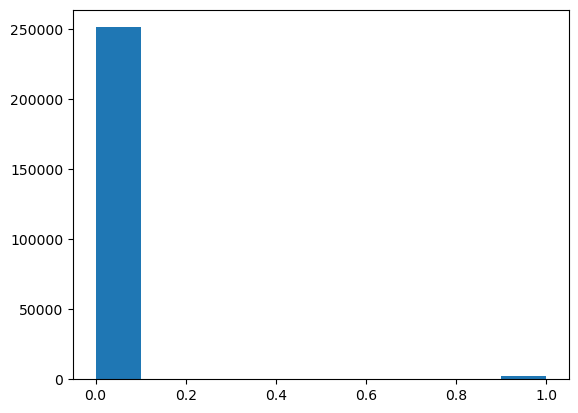

In [10]:
plt.hist(train["target"])

Disbalance observed in target distribution

All of columns which demonstarte sites must be categorical values

In [69]:
def correct_sites(data):
    data = data.replace("nan", "not known")
    return data

for col in test.columns:
    if col == "site1":
        train.loc[:, col] = test.loc[:, col].astype(float)
        test.loc[:, col] = test.loc[:, col].astype(float)
        
        train.loc[:, col] = correct_sites(train.loc[:, col].astype(str)).astype("category")
        test.loc[:, col] = correct_sites(test.loc[:, col].astype(str)).astype("category")
    elif col in site_col:
        train.loc[:, col] = correct_sites(train.loc[:, col].astype(str)).astype("category")
        test.loc[:, col] = correct_sites(test.loc[:, col].astype(str)).astype("category")

Make info about visited sites

In [70]:
site_by_address = {}
for key in data.keys():
    site_by_address[str(float(data[key]))] = re.split(r'[-.]', key)

Sort train and test datasets by site1 column

In [71]:
train = train.sort_values(by="time1", ascending=True)
test = test.sort_values(by="time1", ascending=True)

In [72]:
def fillna_in_date(data):
    result = data.copy()
    for row in range(len(data)):
        index = np.isnan(data.iloc[row, :], where=True)
        for i in range(1, len(data.columns)):
            if index[i]:
                result.iloc[row, i] = result.iloc[row, i-1]
                
    return result

In [73]:
train_time = fillna_in_date(train[time_col])
test_time = fillna_in_date(test[time_col])

for col in time_col:
    train[col] = train_time[col]
    test[col] = test_time[col]

# EDA

Check activity of user by day if that Alice and not

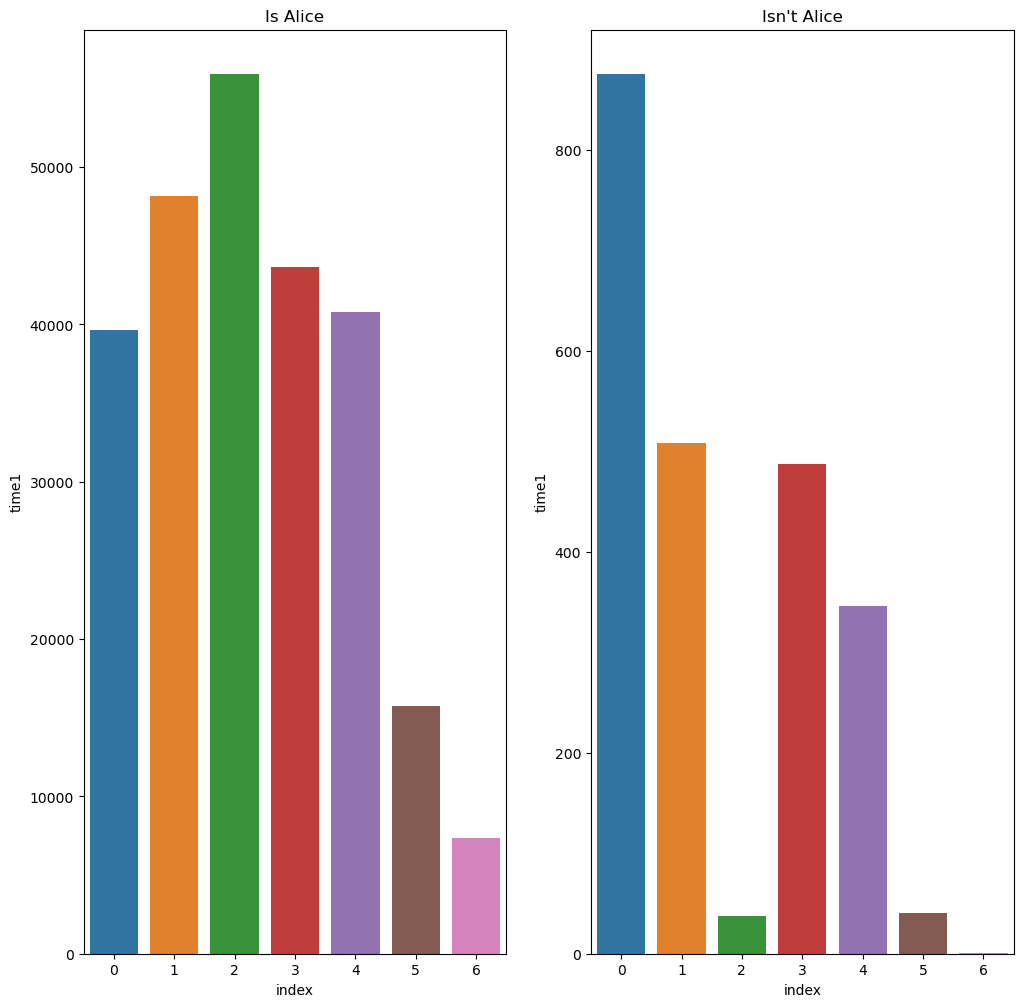

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

for title, ax in zip(["Is Alice", "Isn't Alice"], axs.flat):
    if title == "Is Alice":
        sns.barplot(train[train["target"] == 0].iloc[:, 2].dt.weekday.value_counts().reset_index(),
                    x="index", y="time1", ax=ax)
        ax.set_title(title)
    else:
        sns.barplot(train[train["target"] == 1].iloc[:, 2].dt.weekday.value_counts().reset_index(),
                    x="index", y="time1", ax=ax)
        ax.set_title(title)

This graphics show that Alice's activity in Net aims to normal distribution, but user which not Alice more active on Mondays -> number of week day is important feature

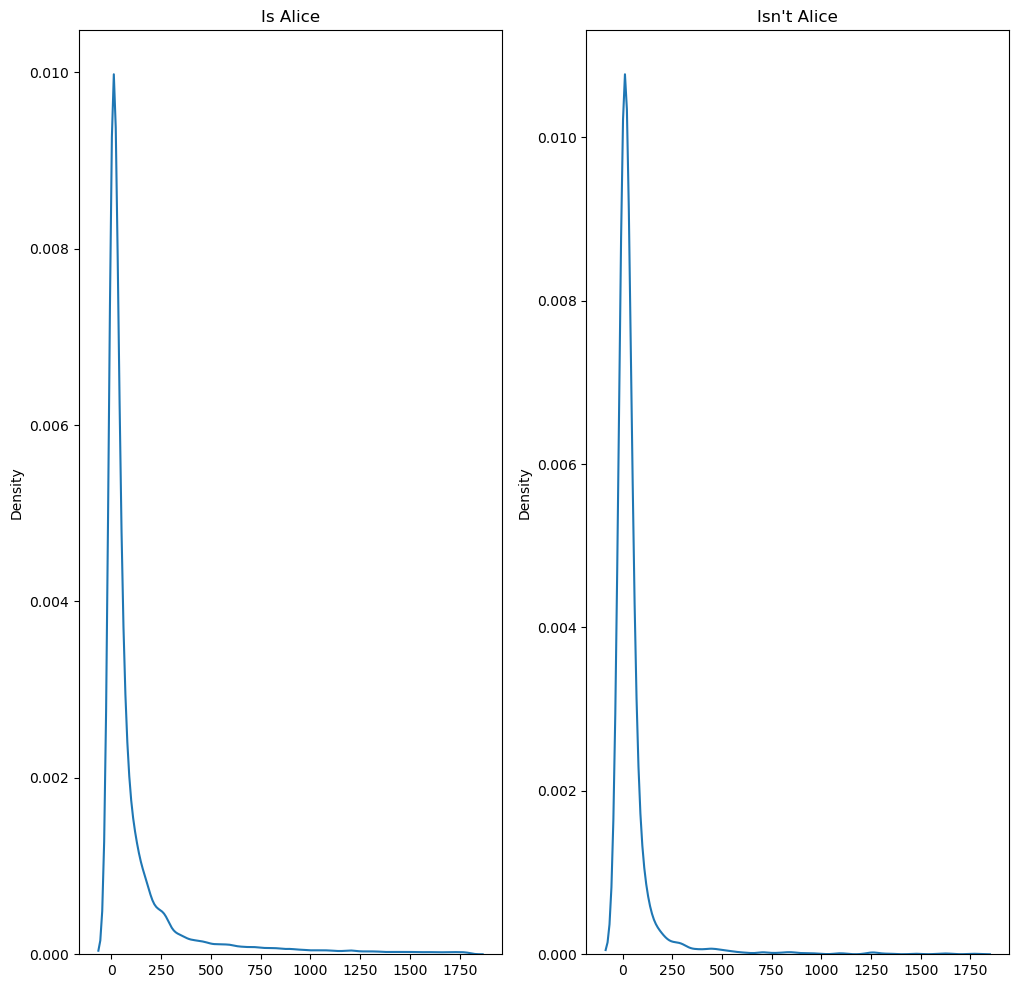

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

for title, ax in zip(["Is Alice", "Isn't Alice"], axs.flat):
    if title == "Is Alice":
        sns.kdeplot((train[train["target"] == 0].loc[:, time_col[-1]] - train[train["target"] == 0].iloc[:, 2]).dt.total_seconds(), ax=ax)
        ax.set_title(title)
    else:
        sns.kdeplot((train[train["target"] == 1].loc[:, time_col[-1]] - train[train["target"] == 1].iloc[:, 2]).dt.total_seconds(), ax=ax)
        ax.set_title(title)

Session length isn't important feature, because distribution of this value are very similar

Alice and not Alice activity by month

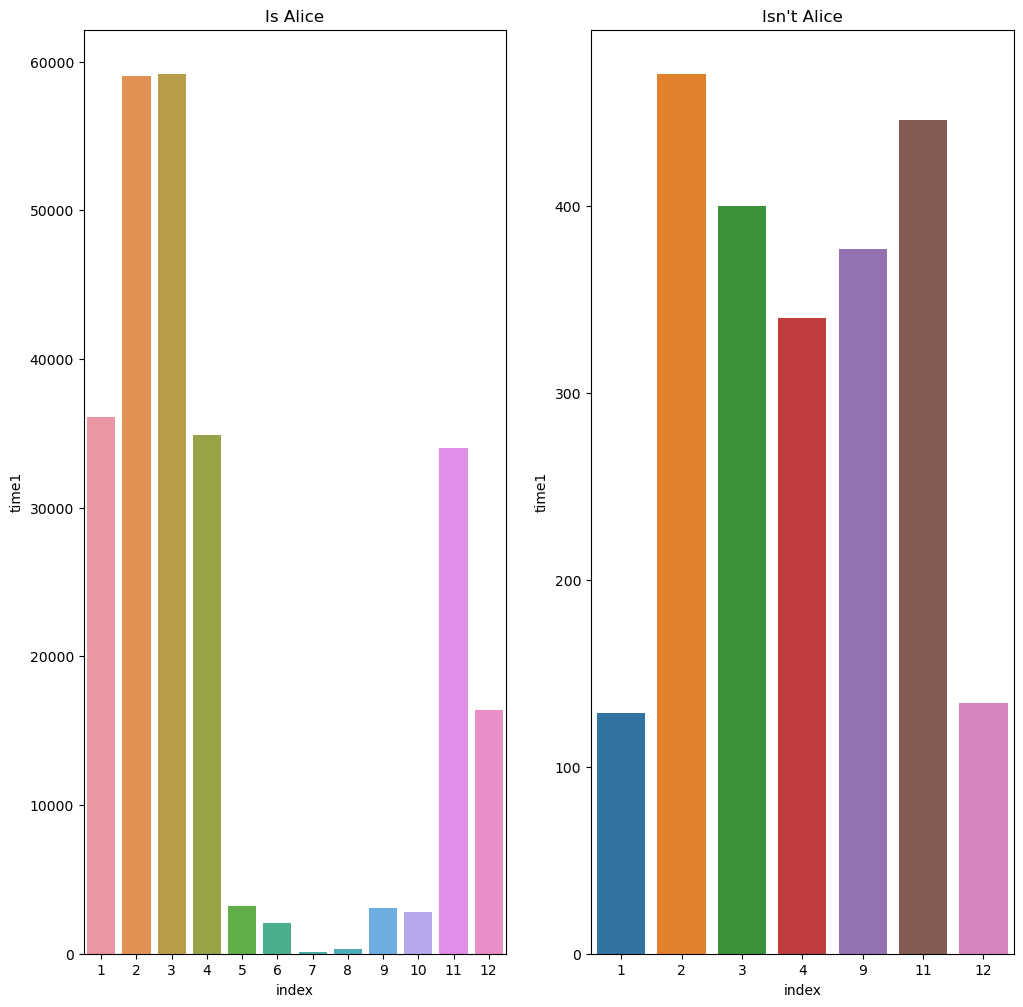

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

for title, ax in zip(["Is Alice", "Isn't Alice"], axs.flat):
    if title == "Is Alice":
        sns.barplot(train[train["target"] == 0].iloc[:, 2].dt.month.value_counts().reset_index(),
                    x="index", y="time1", ax=ax)
        ax.set_title(title)
    else:
        sns.barplot(train[train["target"] == 1].iloc[:, 2].dt.month.value_counts().reset_index(),
                    x="index", y="time1", ax=ax)
        ax.set_title(title)

Let's check how to distribited target by hours of activity

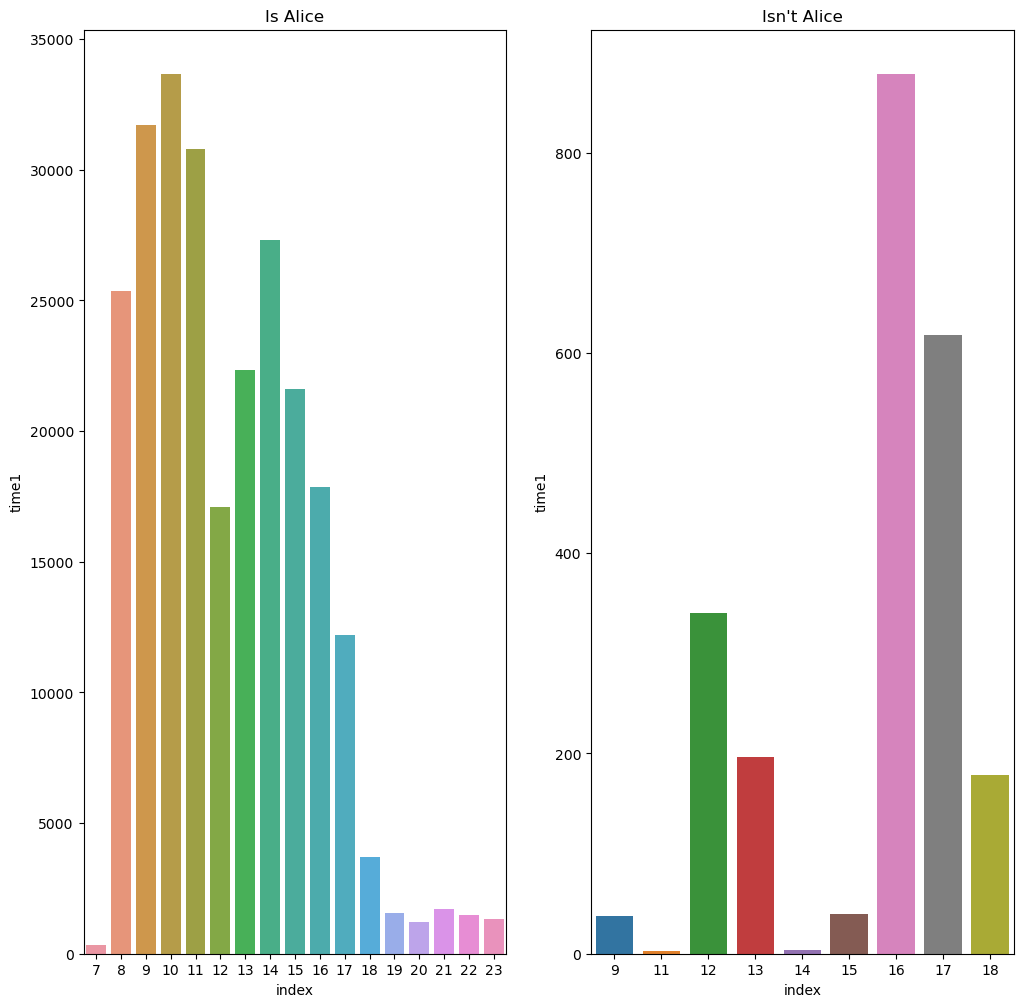

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

for title, ax in zip(["Is Alice", "Isn't Alice"], axs.flat):
    if title == "Is Alice":
        sns.barplot(train[train["target"] == 0].iloc[:, 2].dt.hour.value_counts().reset_index(),
                    x="index", y="time1", ax=ax)
        ax.set_title(title)
    else:
        sns.barplot(train[train["target"] == 1].iloc[:, 2].dt.hour.value_counts().reset_index(),
                    x="index", y="time1", ax=ax)
        ax.set_title(title)

Main time of Alice activity is 9 to 11 a.m. and 1 to 3 p.m

Main time of evildoer's activity is 4 to 5 p.m

Check the unique sites if Alice works and not Alice

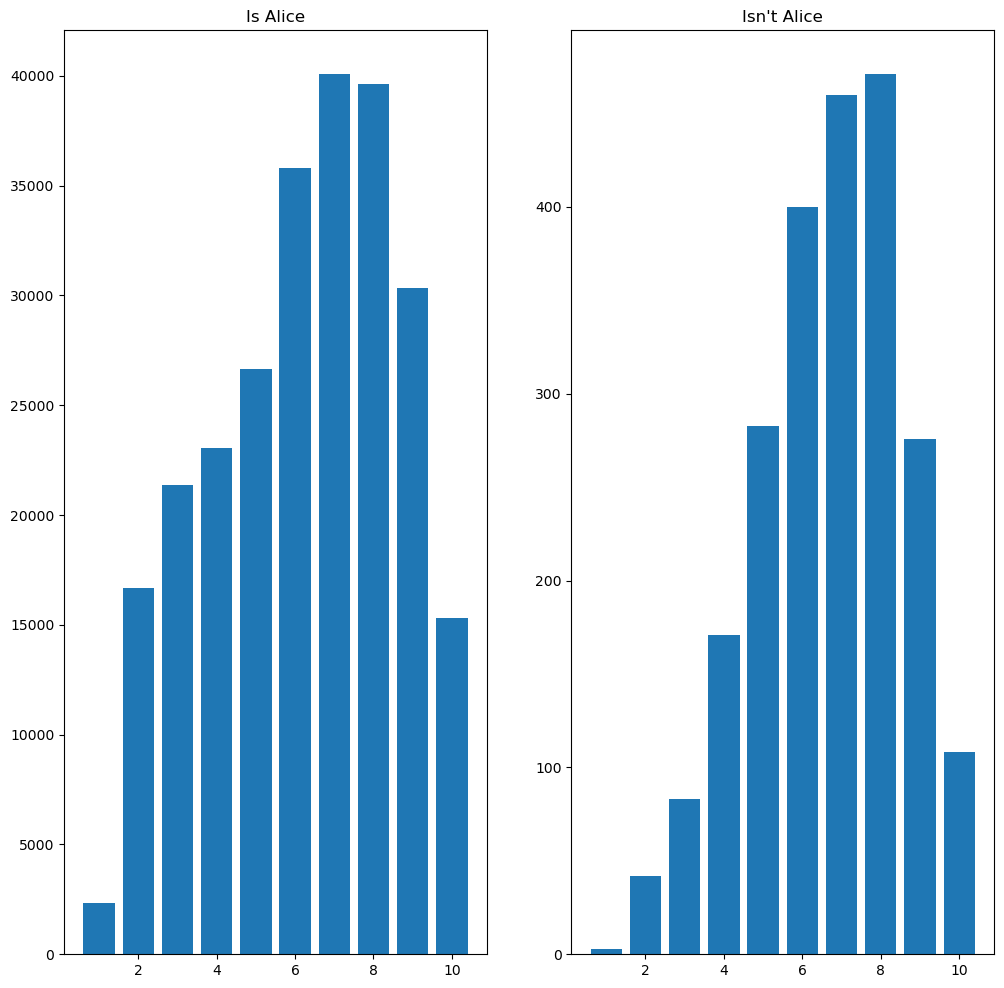

In [24]:
def count_unique(data):
    un_sites = np.array([])
    for row in range(len(data)):
        un_sites = np.append(un_sites, len(data.iloc[row, :].unique()))
    
    return {value: np.count_nonzero(un_sites == value) for value in set(un_sites)}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

for title, ax in zip(["Is Alice", "Isn't Alice"], axs.flat):
    if title == "Is Alice":
        res = count_unique(train[train["target"] == 0][site_col])
        ax.bar(res.keys(), height=res.values())
        ax.set_title(title)
    else:
        res = count_unique(train[train["target"] == 1][site_col])
        ax.bar(res.keys(), height=res.values())
        ax.set_title(title)

There aren't significant differences

Check how distributed mean, max and min time of crosing between sites

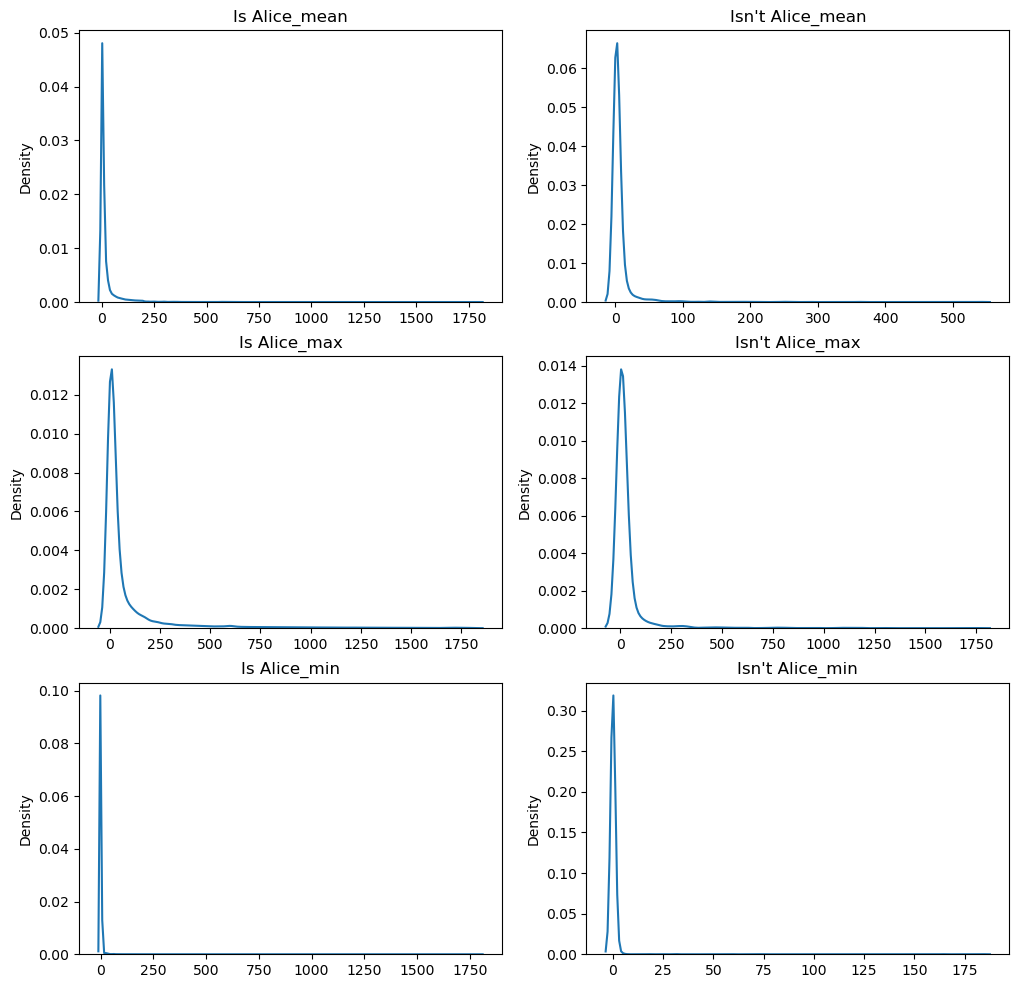

In [25]:
def get_difs(data):
    result = {f"ts_{i+2} - ts{i+1}":(data.iloc[:, i+1] - data.iloc[:, i]).dt.total_seconds()
              for i in range(len(data.columns)-1)}
    return pd.DataFrame(result)

def get_statistics(data):
    return (
        data.apply(np.mean, axis=1),
        data.apply(np.max, axis=1),
        data.apply(np.min, axis=1)
    )

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

is_al = [f"Is Alice_{func}" for func in ("mean", "max", "min")]
is_nal = [f"Isn't Alice_{func}" for func in ("mean", "max", "min")]

stat_isal = get_statistics(get_difs(train[train["target"] == 0][time_col]))
stat_isnal = get_statistics(get_difs(train[train["target"] == 1][time_col]))

for i in range(3):
    sns.kdeplot(stat_isal[i], ax=axs.flat[2*i])
    sns.kdeplot(stat_isnal[i], ax=axs.flat[2*i + 1])
    axs.flat[2*i].set_title(is_al[i])
    axs.flat[2*i + 1].set_title(is_nal[i])

No differences

# Feature engineering

Let's try to generate new time features

Split data by components

In [76]:
for col in time_col:
    train.loc[:, f"hour_{col}"] = train.loc[:, col].dt.hour
    train.loc[:, f"minute_{col}"] = train.loc[:, col].dt.minute
#     train.loc[:, f"second_{col}"] = train.loc[:, col].dt.second
    
    test.loc[:, f"hour_{col}"] = test.loc[:, col].dt.hour
    test.loc[:, f"minute_{col}"] = test.loc[:, col].dt.minute
#     test.loc[:, f"second_{col}"] = test.loc[:, col].dt.second

Bool flag: is weekend or not + generate mark of weekday

In [77]:
train.loc[:, "is_weekend"] = (train.iloc[:, 2].dt.weekday >= 5).astype(int)
train.loc[:, "day_number"] = train.iloc[:, 2].dt.weekday

test.loc[:, "is_weekend"] = (test.iloc[:, 2].dt.weekday >= 5).astype(int)
test.loc[:, "day_number"] = test.iloc[:, 2].dt.weekday

Bool flag: time period is belong to main Alice activity or evildoers activity

In [78]:
temp_values = []
for row in range(len(train)):
    if train.iloc[row, 2].hour in (9, 10, 11, 13, 14, 15):
        temp_values.append(1)
    elif train.iloc[row, 2].hour in (16, 17):
        temp_values.append(-1)
    else:
        temp_values.append(0)
        
train.loc[:, "activity_flag"] = temp_values

temp_values = []
for row in range(len(test)):
    if test.iloc[row, 2].hour in (9, 10, 11, 13, 14, 15):
        temp_values.append(1)
    elif test.iloc[row, 2].hour in (16, 17):
        temp_values.append(-1)
    else:
        temp_values.append(0)
        
test.loc[:, "activity_flag"] = temp_values

Check sites for Alice end evildoers

In [ ]:
# tr_un = np.array([])
# test_un = np.array([])

# for col in site_col:
#     tr_un = np.append(tr_un, np.unique(train[col]))
#     test_un = np.append(test_un, np.unique(test[col]))
    
# tr_un = np.unique(tr_un)
# test_un = np.unique(test_un)

# a_sites = np.array([])
# not_a_sites = np.array([])

# for col in site_col:
#     a_sites = np.append(a_sites, np.unique(train[train["target"] == 0][col]))
#     not_a_sites = np.append(not_a_sites, np.unique(train[train["target"] == 1][col]))
    
# a_sites = np.unique(a_sites)
# not_a_sites = np.unique(not_a_sites)

# a_sites = set(a_sites) - set(not_a_sites)
# not_a_sites = set(not_a_sites) - set(a_sites)

# a_sites = set(alice_sites) - set(not_alice_sites)
# not_a_sites = set(not_alice_sites) - set(alice_sites)
# test_un = set(test_un)
# unk_sites = set(alice_sites) & set(not_alice_sites)

# neutral = np.array([0 for _ in range(len(train))])
# not_alice = np.array([0 for _ in range(len(train))])
# alice = np.array([0 for _ in range(len(train))])

# for col in site_col:
#     data = train[col]
#     neutral += np.array([1 if data[index] in unk_sites else 0 for index in range(len(train))])
#     not_alice += np.array([1 if data[index] in not_a_sites else 0 for index in range(len(train))])
#     alice += np.array([1 if data[index] in a_sites else 0 for index in range(len(train))])
    
# train.loc[:, "not_known"] = neutral
# train.loc[:, "alice_sites"] = alice
# train.loc[:, "not_alice_sites"] = not_alice
    
# neutral = np.array([0 for _ in range(len(test))])
# not_alice = np.array([0 for _ in range(len(test))])
# alice = np.array([0 for _ in range(len(test))])
    
# for col in site_col:
#     data = test[col]
#     neutral += np.array([1 if data[index] in unk_sites else 0 for index in range(len(test))])
#     not_alice += np.array([1 if data[index] in not_a_sites else 0 for index in range(len(test))])
#     alice += np.array([1 if data[index] in a_sites else 0 for index in range(len(test))])
    
# test.loc[:, "not_known"] = neutral
# test.loc[:, "alice_sites"] = alice
# test.loc[:, "not_alice_sites"] = not_alice

Count of unique sites per one work session

In [79]:
values = np.array([])
for row in range(len(train)):
    values = np.append(values, len(np.unique(train.iloc[row, :][site_col])))
train.loc[:, "unq_sites_per_session"] = values

values = np.array([])
for row in range(len(test)):
    values = np.append(values, len(np.unique(test.iloc[row, :][site_col])))
test.loc[:, "unq_sites_per_session"] = values

Count the "speed" of switching between sites on the average in work session

In [80]:
train.loc[:, "switch_speed_sec"] = train["unq_sites_per_session"] / (train[time_col[-1]] - train[time_col[0]]).dt.total_seconds()
test.loc[:, "switch_speed_sec"] = test["unq_sites_per_session"] / (test[time_col[-1]] - test[time_col[0]]).dt.total_seconds()

In [81]:
train.loc[:, "unq_sites_per_session"] = train["unq_sites_per_session"].astype(int)
test.loc[:, "unq_sites_per_session"] = test["unq_sites_per_session"].astype(int)

Get length of time series before going to other site in one work session

In [ ]:
# for i in range(len(time_col) - 1):
#     train.loc[:, f"ts_{i+2} - ts_{i+1}"] = train[time_col[i+1]] - train[time_col[i]]
#     test.loc[:, f"ts_{i+2} - ts_{i+1}"] = test[time_col[i+1]] - test[time_col[i]]

# for col in test.columns:
#     if col.startswith("ts"):
#         train.loc[:, col] = train.loc[:, col].dt.total_seconds()
#         test.loc[:, col] = test.loc[:, col].dt.total_seconds()

Extracting metadata about sites

In [82]:
raw_data = {}
raw_data['not known'] = {
    'site_len': 0,
    'symbols': 0,
    'digits': 0,
    'words': 0
}
for key in data.keys():
    raw_data[str(float(data[key]))] = {'site_len': len(key),
                                       'symbols': len(re.findall(r'_|\W', key)),
                                       'digits': len(re.findall(r'\d', key)),
                                       'words': len(site_by_address[str(float(data[key]))])}
raw_data = pd.DataFrame(raw_data).T

In [83]:
def generate_site_features(data, site_col, raw_data):
    result = pd.DataFrame()
    for col in site_col:
        temp = raw_data.loc[data[col], :].reset_index().iloc[:, 1:]
        temp.columns = [col + "_" + column for column in temp.columns]
        result = pd.concat([result, temp], axis=1)
        
    return result

train = pd.concat([train, generate_site_features(train, site_col, raw_data)], axis=1)
test = pd.concat([test, generate_site_features(test, site_col, raw_data)], axis=1)

In [84]:
len_col, dig_col, word_col, symb_col = [], [], [], []

len_col = train.columns[-40::4]
symb_col = train.columns[-39::4]
dig_col = train.columns[-38::4]
word_col = train.columns[-37::4]

for col_set, name in zip([len_col, dig_col, word_col, symb_col],
                         ["len", "symbols", "digits", "words"]):
    temp = train.loc[:, col_set].apply([np.mean, np.max, np.min, np.median, np.std], axis=1)
    temp.columns = [f'{name}_mean', f'{name}_max', f'{name}_min', f'{name}_median', f'{name}_std']
    train = pd.concat([train, temp], axis=1)
    
for col_set, name in zip([len_col, dig_col, word_col, symb_col],
                         ["len", "symbols", "digits", "words"]):
    temp = test.loc[:, col_set].apply([np.mean, np.max, np.min, np.median, np.std], axis=1)
    temp.columns = [f'{name}_mean', f'{name}_max', f'{name}_min', f'{name}_median', f'{name}_std']
    test = pd.concat([test, temp], axis=1)

Try to estimate similarity for checking sites

In [49]:
# sessions = pd.concat((train[site_col], test[site_col]), axis=0)
# corpus = sessions[site_col[0]].to_numpy().reshape(-1, 1)

# for col in site_col[1:]:
#     corpus = np.hstack((corpus, sessions[col].to_numpy().reshape(-1, 1)))

In [85]:
train_df = train.drop([*time_col, 'session_id', *site_col], axis=1).dropna()

([<matplotlib.axis.XTick at 0x7e27345d2560>,
 [Text(0, 0, 'hour_time1'),
  Text(1, 0, 'minute_time1'),
  Text(2, 0, 'hour_time2'),
  Text(3, 0, 'minute_time2'),
  Text(4, 0, 'hour_time3'),
  Text(5, 0, 'minute_time3'),
  Text(6, 0, 'hour_time4'),
  Text(7, 0, 'minute_time4'),
  Text(8, 0, 'hour_time5'),
  Text(9, 0, 'minute_time5'),
  Text(10, 0, 'hour_time6'),
  Text(11, 0, 'minute_time6'),
  Text(12, 0, 'hour_time7'),
  Text(13, 0, 'minute_time7'),
  Text(14, 0, 'hour_time8'),
  Text(15, 0, 'minute_time8'),
  Text(16, 0, 'hour_time9'),
  Text(17, 0, 'minute_time9'),
  Text(18, 0, 'hour_time10'),
  Text(19, 0, 'minute_time10'),
  Text(20, 0, 'is_weekend'),
  Text(21, 0, 'day_number'),
  Text(22, 0, 'activity_flag'),
  Text(23, 0, 'unq_sites_per_session'),
  Text(24, 0, 'site1_site_len'),
  Text(25, 0, 'site1_symbols'),
  Text(26, 0, 'site1_digits'),
  Text(27, 0, 'site1_words'),
  Text(28, 0, 'site2_site_len'),
  Text(29, 0, 'site2_symbols'),
  Text(30, 0, 'site2_digits'),
  Text(31, 

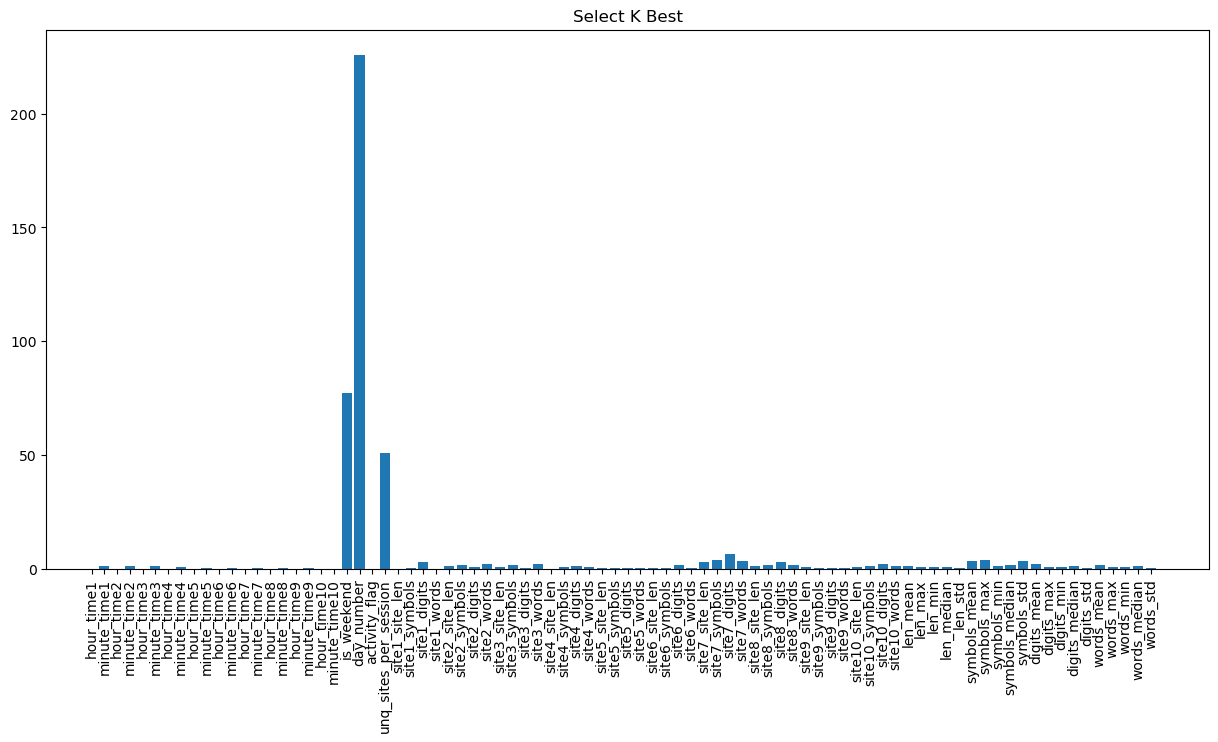

In [86]:
plt.figure(figsize=(15, 7))
plt.title('Select K Best', fontsize=12)
selector = SelectKBest(k='all')
selector.fit(train_df.drop(["target", "switch_speed_sec"], axis=1), train_df["target"])
scores = -np.log(selector.pvalues_)
plt.bar(range(len(train_df.drop(["target", "switch_speed_sec"], axis=1).columns.to_list())), scores)
plt.xticks(range(len(train_df.drop(["target", "switch_speed_sec"], axis=1).columns.to_list())),
           train_df.drop(["target", "switch_speed_sec"], axis=1).columns.to_list(),
           rotation='vertical')

In [87]:
train = train.drop([*[f"site{i}_site_len" for i in range(1, 11)], "activity_flag"], axis=1)

In [88]:
test = test.drop([*[f"site{i}_site_len" for i in range(1, 11)], "activity_flag"], axis=1)

# Catboost blending models + feature selection

Plot validation and learning curves for overfitting exploring (n_estimators, l2_leaf_reg)

In [ ]:
n_estimators = np.arange(100, 401, 50)
l2_leaf_reg = np.arange(1, 3.1, 0.2)

X = train.drop([*time_col, "target", "session_id"], axis=1)
y = train["target"]
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=.2, random_state=17,
                                                         shuffle=True, stratify=y)

learning_rates = []
holdout_rates = []

for n_est in n_estimators:
    model = CatBoostClassifier(learning_rate=0.05, l2_leaf_reg=1,
                               verbose=0, random_state=i*2, n_estimators=n_est, max_depth=8,
                               cat_features=["is_weekend", "day_number", "activity_flag", *site_col,
                                             "unq_sites_per_session"])
    model.fit(X_train, y_train)
    
    res_roc_auc = 0
    learn_roc_auc = 0  
    
    holdout_rates.append(roc_auc_score(model.predict(X_holdout), y_holdout))
    learning_rates.append(roc_auc_score(model.predict(X_train), y_train))
    
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

sns.lineplot(x=n_estimators, y=learning_rates, ax=axs.flat[0])
axs.flat[0].set_title("Learning curve")
axs.flat[0].set_xlabel("n_estimators")
axs.flat[0].set_ylabel("ROC-AUC")

sns.lineplot(x=n_estimators, y=holdout_rates, ax=axs.flat[1])
axs.flat[1].set_title("Validation curve")
axs.flat[1].set_xlabel("n_estimators")
axs.flat[1].set_ylabel("ROC-AUC")

best_n_estimators = n_estimators[holdout_rates.index(np.max(holdout_rates))] (400)

In [ ]:
learning_rates = []
holdout_rates = []

for l2_reg in l2_leaf_reg:
    model = CatBoostClassifier(learning_rate=0.05, l2_leaf_reg=l2_reg,
                               verbose=0, random_state=i*2, n_estimators=best_n_estimators, max_depth=8,
                               cat_features=["is_weekend", "day_number", "activity_flag", *site_col,
                                             "unq_sites_per_session"])
    model.fit(X_train, y_train)
    
    res_roc_auc = 0
    learn_roc_auc = 0  
    
    holdout_rates.append(roc_auc_score(model.predict(X_holdout), y_holdout))
    learning_rates.append(roc_auc_score(model.predict(X_train), y_train))
    
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

sns.lineplot(x=l2_leaf_reg, y=learning_rates, ax=axs.flat[0])
axs.flat[0].set_title("Learning curve")
axs.flat[0].set_xlabel("n_estimators")
axs.flat[0].set_ylabel("ROC-AUC")

sns.lineplot(x=l2_leaf_reg, y=holdout_rates, ax=axs.flat[1])
axs.flat[1].set_title("Validation curve")
axs.flat[1].set_xlabel("n_estimators")
axs.flat[1].set_ylabel("ROC-AUC")

best_l2_reg = l2_leaf_reg[holdout_rates.index(np.max(holdout_rates))]

In [32]:
X = train.drop([*time_col, "target", "session_id"], axis=1)
y = train["target"]
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=.2, random_state=17,
                                                         shuffle=True, stratify=y)

models = []
for i in range(5):
    model = CatBoostClassifier(learning_rate=0.05, l2_leaf_reg=1,
                               verbose=100, random_state=i*2, n_estimators=best_n_estimators, max_depth=8,
                               cat_features=["is_weekend", "day_number", "activity_flag", *site_col,
                                             "unq_sites_per_session"])
    model.fit(X_train, y_train)
    models.append(model)

0:	learn: 0.5819659	total: 727ms	remaining: 4m 50s
100:	learn: 0.0196816	total: 1m 13s	remaining: 3m 36s
200:	learn: 0.0167792	total: 2m 28s	remaining: 2m 27s
300:	learn: 0.0149335	total: 3m 43s	remaining: 1m 13s
399:	learn: 0.0133791	total: 4m 57s	remaining: 0us
0:	learn: 0.5755012	total: 769ms	remaining: 5m 6s
100:	learn: 0.0195662	total: 1m 12s	remaining: 3m 36s
200:	learn: 0.0167280	total: 2m 28s	remaining: 2m 26s
300:	learn: 0.0147711	total: 3m 44s	remaining: 1m 13s
399:	learn: 0.0132984	total: 5m	remaining: 0us
0:	learn: 0.5807910	total: 811ms	remaining: 5m 23s
100:	learn: 0.0201028	total: 1m 13s	remaining: 3m 37s
200:	learn: 0.0169750	total: 2m 30s	remaining: 2m 28s
300:	learn: 0.0151011	total: 3m 45s	remaining: 1m 14s
399:	learn: 0.0135968	total: 5m	remaining: 0us
0:	learn: 0.5679548	total: 597ms	remaining: 3m 58s
100:	learn: 0.0200023	total: 1m 11s	remaining: 3m 32s
200:	learn: 0.0169835	total: 2m 25s	remaining: 2m 24s
300:	learn: 0.0152584	total: 3m 40s	remaining: 1m 12s
399:

Average importance by all models

<Axes: >

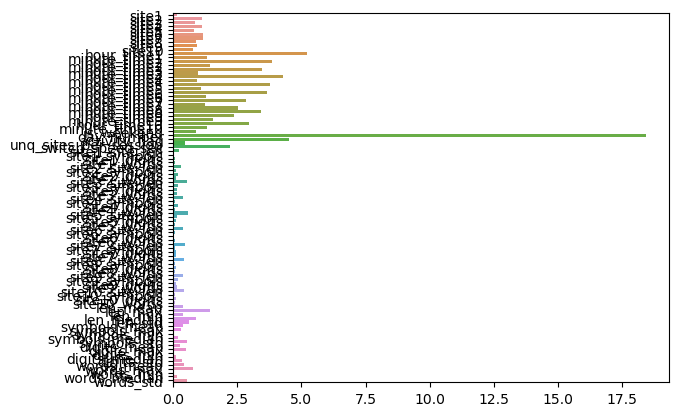

In [33]:
importances = np.array([0.0 for _ in range(len(train.drop([*time_col, "target", "session_id"],
                                                          axis=1).columns))])

for model in models:
    importances += np.array(model.feature_importances_)

importances /= len(models)
sns.barplot(x=importances, y=train.drop([*time_col, "target", "session_id"], axis=1).columns,
           orient='h')

In [ ]:
fi = {train.drop([*time_col, "target", "session_id"],axis=1).columns[i]: importances[i]
      for i in range(len(train.drop([*time_col, "target", "session_id"], axis=1).columns))}
fi = dict(sorted(fi.items(), key=lambda item: item[1], reverse=True))

n_count = np.array([5, 10, 20, 30, 50, 70, 80, 90, 95, 100])
imp = []
for i in range(len(n_count)):
    temp_features = list(fi.keys())[:n_count[i]]
    model = CatBoostClassifier(learning_rate=0.05, l2_leaf_reg=1,
                               verbose=0, random_state=i*2, n_estimators=best_n_estimators, max_depth=8,
                               cat_features=list(set(["is_weekend", "day_number", "activity_flag", *site_col,
                                             "unq_sites_per_session"]) & set(temp_features)))
    model.fit(X_train[temp_features], y_train)
    imp.append(roc_auc_score(model.predict(X_holdout[temp_features]), y_holdout))
               
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sns.lineplot(x=n_count, y=imp, ax=ax)
ax.set_title("Validation curve")
ax.set_xtitle("Count of features")
ax.set_yttile("ROC-AUC")

In [ ]:
model = CatBoostClassifier(learning_rate=0.05, l2_leaf_reg=1,
                               verbose=50, random_state=i**2, n_estimators=400,
                               cat_features=["is_weekend", "day_number", "activity_flag", *site_col,
                                            "not_known", "alice_sites", "not_alice_sites", "unq_sites_per_session"])
grid = {
    "max_depth":np.arange(8, 11, 1)
}

result = model.grid_search(grid, X=X_train, y=y_train, plot=True, verbose=False)

In [ ]:
result["params"]

In [ ]:
res_roc_auc = 0
for i in range(len(models)):
    y_pred = models[i].predict(X_holdout)
    res_roc_auc += roc_auc_score(y_pred, y_holdout)
    
res_roc_auc /= 5
res_roc_auc

# Logistic Regression

In [134]:
# tss = TimeSeriesSplit(n_splits=5)
# skf = StratifiedKFold(n_splits=5)

In [99]:
# train['switch_speed_sec'] = [0 if np.isinf(train['switch_speed_sec'][i]) else train['switch_speed_sec'][i]
#                             for i in range(len(train))]
# test['switch_speed_sec'] = [0 if np.isinf(test['switch_speed_sec'][i]) else test['switch_speed_sec'][i]
#                             for i in range(len(test))]

In [144]:
# train, test = train.replace("not known", '0.0'), test.replace("not known", '0.0')
# for col in site_col:
#     train[col] = train[col].astype(float)
#     test[col] = test[col].astype(float)

In [ ]:
# param = {'C': np.logspace(-1,1,20)}
# grid = GridSearchCV(LogisticRegression(random_state=17), param, cv=skf, scoring='roc_auc',
#                    n_jobs=-1, verbose=50)
# grid.fit(train.drop(["target", *time_col, 'session_id'], axis=1), train["target"])

In [149]:
# grid_result = pd.DataFrame(grid.cv_results_)

In [150]:
# grid_result[['param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_C,mean_test_score,std_test_score,rank_test_score
0,0.1,0.430443,0.037807,16
1,0.127427,0.451901,0.024671,2
2,0.162378,0.434881,0.027620,8
3,0.206914,0.430504,0.024652,15
4,0.263665,0.436523,0.025529,6
5,0.335982,0.423173,0.038352,19
6,0.428133,0.428398,0.021715,18
7,0.545559,0.452296,0.035703,1
8,0.695193,0.420711,0.033675,20
9,0.885867,0.440434,0.035102,5


[CV 3/5; 1/20] START C=0.1......................................................
[CV 3/5; 1/20] END .......................C=0.1;, score=0.446 total time=   9.3s
[CV 1/5; 2/20] START C=0.12742749857031338......................................
[CV 1/5; 2/20] END .......C=0.12742749857031338;, score=0.434 total time=   9.2s
[CV 2/5; 3/20] START C=0.16237767391887217......................................
[CV 2/5; 3/20] END .......C=0.16237767391887217;, score=0.481 total time=   8.5s
[CV 5/5; 3/20] START C=0.16237767391887217......................................
[CV 5/5; 3/20] END .......C=0.16237767391887217;, score=0.432 total time=   8.0s
[CV 4/5; 4/20] START C=0.20691380811147897......................................
[CV 4/5; 4/20] END .......C=0.20691380811147897;, score=0.395 total time=   8.3s
[CV 3/5; 5/20] START C=0.26366508987303583......................................
[CV 3/5; 5/20] END .......C=0.26366508987303583;, score=0.433 total time=   8.3s
[CV 2/5; 6/20] START C=0.335

# Predictions

In [193]:
X_test = test.drop([*time_col, 'session_id'], axis=1)

predictions = grid.best_estimator_.predict_proba(X_test)[:, 1]

In [188]:
result = pd.concat([test.iloc[:, 0], pd.DataFrame(predictions)], axis=1)
result.columns = ["session_id", "target"]

result.to_csv("/kaggle/working/result.csv", index=False)

In [190]:
result.to_csv("/kaggle/working/result.csv", index=False)